In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
human_data = pd.read_table('human.txt')
#chimp_data = pd.read_table('chimpanzee.txt')
#dog_data = pd.read_table('/kaggle/input/dna-sequence-dataset/dog.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [36]:
def getKmers(sequence , size = 6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [37]:
human_data['words'] = human_data.apply(lambda x : getKmers(x['sequence']) , axis = 1)
human_data = human_data.drop('sequence' , axis = 1)

In [38]:
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [39]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human_data.iloc[: , 0].values

In [40]:
print(human_texts[2])

atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggcatt gcattt catttg atttgg tttggg ttgggc tgggcg gggcgc ggcgct gcgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttggc ttggca tggcag ggcagt gcagtg cagtga agtgat gtgatg tgatga gatgat atgatt tgattg gattgc attgcc ttgcct tgcctt gccttt cctttc ctttct tttctg ttctgt tctgtt ctgttc tgttca gttcag ttcagt tcagtg cagtgt agtgtc gtgtct tgtctg gtctga tctgag ctgagt tgagtg gagtgc agtgct gtgcta tgctat gctatg ctatga tatgaa atgaag tgaaga gaagat aagatt agattg gattgc attgca ttgcac tgcaca gcacac cacaca acacag cacaga acagag cagagg agaggt gaggtc aggtcc ggtcca gtccag tccaga ccagat cagatg agatgc gatgca atgcat tgcatt gcattc cattcc attccg ttccgt tccgtt ccgttt cgtttt gttttg ttttga tttgag ttgaga tgagaa gagaat agaatg gaatgt aatgtc atgtca tgtcaa gtcaat tcaatg caatgg aatgga atggat tggata ggatac gataca atacac tacacc acacca caccaa accaac ccaact caactg aactgc actgct ctgctg tgctgc gctgct ctgctt tgcttt gctttg ctttgg tttgga ttggat tggatt ggattt gatttc atttca tttcac ttcacc tcaccg caccgg accggt

In [41]:
y_data

array([4, 4, 3, ..., 6, 6, 6], dtype=int64)

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range = (4,4))
X = cv.fit_transform(human_texts)

In [43]:
print(X.shape)

(4380, 232414)


<Axes: xlabel='class'>

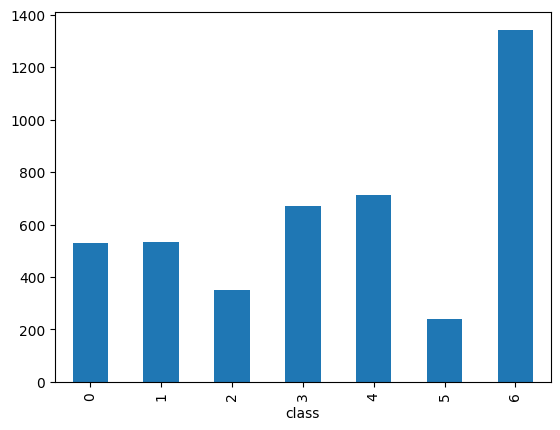

In [44]:
human_data['class'].value_counts().sort_index().plot.bar()

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train , X_test , y_train , y_test = train_test_split(X,y_data, test_size = 0.2, random_state = 42)

In [46]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


In [47]:
train_classes = pd.Series(y_train).value_counts() / len(y_train) * 100
test_classes = pd.Series(y_test).value_counts() / len(y_test) * 100
print(f'class train   test')
for index, train_, test_ in zip(train_classes.sort_index().index, train_classes.sort_index(), test_classes.sort_index()):
    print(f'{index:^5} {train_:^3.0f} % - {test_:^2.0f} %')

class train   test
  0   12  % - 12 %
  1   12  % - 12 %
  2    8  % - 9  %
  3   16  % - 14 %
  4   16  % - 17 %
  5    5  % - 6  %
  6   31  % - 30 %


In [48]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],  # Критерий разбиения
    'max_depth': [None, 10, 20, 30],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # Минимальное количество выборок для разбиения
    'min_samples_leaf': [1, 2, 4],    # Минимальное количество выборок в листе
}

decision_tree  = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [49]:
best_model = grid_search.best_estimator_
print(best_model)

DecisionTreeClassifier(min_samples_split=5, random_state=42)


In [50]:
y_pred = best_model.predict(X_test)

Confusion matrix 

Predicted   0   1   2   3    4   5    6
Actual                                 
0          77   4   3   7    4   1    6
1           4  84   3   2    1   0   12
2           1   1  66   1    0   1    8
3           5   6   3  97    4   0   10
4           6   0   1   8  121   1   12
5           2   3   1   1    1  38    5
6           7   5   2   5    6   1  239
accuracy = 0.824 
precision = 0.826 
 recall = 0.824 
 f1 = 0.824


Text(0.5, 1.0, 'Confusion Matrix')

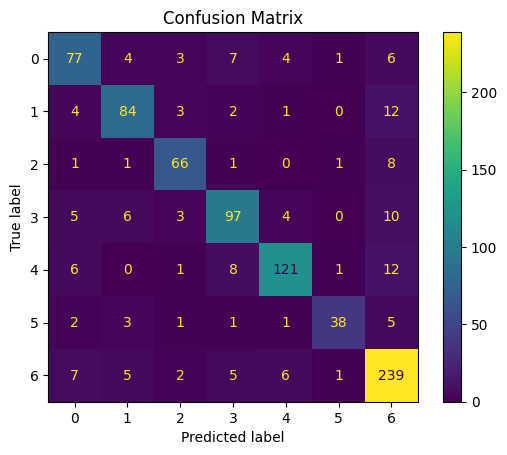

In [51]:
from sklearn.metrics import accuracy_score , f1_score , precision_score , recall_score, confusion_matrix, ConfusionMatrixDisplay

print("Confusion matrix \n")

print(pd.crosstab(pd.Series(y_test , name = "Actual") , pd.Series(y_pred , name = "Predicted")))
def get_metrics(y_test , y_predicted):
    accuracy = accuracy_score(y_test , y_predicted)
    precision = precision_score(y_test , y_predicted , average = "weighted")
    recall = recall_score(y_test , y_predicted , average = "weighted")
    f1 = f1_score(y_test , y_predicted , average = "weighted")
    return accuracy , precision , recall , f1

accuracy , precision , recall , f1 = get_metrics(y_test , y_pred)
print("accuracy = %.3f \nprecision = %.3f \n recall = %.3f \n f1 = %.3f" % (accuracy , precision , recall , f1))

model_matrix_ = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6])
model_mat_plt_ = ConfusionMatrixDisplay(confusion_matrix=model_matrix_)
model_mat_plt_.plot()
plt.title('Confusion Matrix')